In [2]:
# LO CIRCUITS
# can always get a unitary matrix from a LO circuit in Perceval
# we can convert a matrix into a ZW circuit in optyx
# the opposite way is how we evaluate LO circuits in perce|val

In [3]:
# MORE GENERAL CIRCUITS
#

In [4]:
import numpy as np

import perceval as pcvl
from perceval import catalog

In [5]:
import numpy as np

import perceval as pcvl
from perceval import catalog
p = pcvl.Processor("SLOS", 6)
p.add(0, catalog["postprocessed cnot"].build_processor())
p.add(0, pcvl.BS.H())
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())
p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())
# 2 measured modes
# offset = 0 means that there is 0 empty modes between the measured modes and the circuit
# the default circuit is an empty circuit
ff_X = pcvl.FFCircuitProvider(2, 0, pcvl.Circuit(2))

# Now if we measure a logical state |1>, we need to perform a permutation of the modes
ff_X.add_configuration([0, 1], pcvl.PERM([1, 0]))

p.add(2, ff_X)
phi = pcvl.P("phi")
# Like Circuits and Processors, we can chain the `add` methods
ff_Z = pcvl.FFConfigurator(2, 3, pcvl.PS(phi), {"phi": 0}).add_configuration([0, 1], {"phi": np.pi})
p.add(0, ff_Z)

In [6]:
import numpy as np

import perceval as pcvl
from perceval import catalog


# Creation of the qubit to transmit
alpha = np.random.random()
beta = np.random.random() * np.exp(2 * np.pi * 1j * np.random.random())
# alpha |0> + beta |1> in dual rail encoding
to_transmit = (0.7071067811865476+0j)*pcvl.BasicState([1, 0]) + (-0.21850801222441052+0.6724985119639574j)*pcvl.BasicState([0, 1]) 
to_transmit.normalize()

alpha = to_transmit[pcvl.BasicState([1, 0])]  # Normalized
beta = to_transmit[pcvl.BasicState([0, 1])]

sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")

input_state = to_transmit * bell_state
#input_state = bell_state
p.min_detected_photons_filter(2)

# Since we use a "custom" (understand not a BasicState) input state,
# we have to add the heralds from the post-processed cnot manually
input_state *= pcvl.BasicState([0, 0])

p.with_input(input_state)

res = p.probs()
print(res)

{'results': BSDistribution(<class 'float'>, {|1,0,1,0,1,0>: 0.12500000000000003, |0,1,1,0,1,0>: 0.12499999999999996, |0,1,1,0,0,1>: 0.12500000000000003, |1,0,0,1,1,0>: 0.125, |1,0,0,1,0,1>: 0.125, |1,0,1,0,0,1>: 0.12500000000000003, |0,1,0,1,1,0>: 0.12499999999999996, |0,1,0,1,0,1>: 0.12500000000000003}), 'global_perf': 0.11111111111111112}


In [7]:
bell_state

0.707*|0,1,0,1>+0.707*|1,0,1,0>

In [8]:
to_transmit

(-0.219+0.672I)*|0,1>+0.707*|1,0>

In [9]:
input_state

(-0.155+0.476I)*|0,1,0,1,0,1,0,0>+(-0.155+0.476I)*|0,1,1,0,1,0,0,0>+0.5*|1,0,0,1,0,1,0,0>+0.5*|1,0,1,0,1,0,0,0>

In [ ]:
from optyx._utils import matrix_to_zw
from optyx import Channel, mode, qmode, photonic, bit
from optyx.classical import ClassicalFunction, BitControlledGate
from perceval.components.detector import DetectionType
from optyx.core.channel import Spider, Diagram, Measure
from optyx.classical import Select
from optyx.photonic import Create
from optyx.postselect_parser import compile_postselect
from optyx.core.zw import Endo


def invert_perm(p):
    q = [0] * len(p)
    for out, inn in enumerate(p):
        q[inn] = out
    return q

def from_perceval(p):
    n_modes = p.circuit_size
    circuit = photonic.Id(n_modes)
    heralds = p.heralds

    if heralds is not None:
        layer = photonic.Id(0)
        for m in range(n_modes):
            if m in heralds:
                layer @= Create(heralds[m])
            else:
                layer @= photonic.Id(1)
        circuit = layer >> circuit

    for c in p.components:
        component = c[1]

        wires = c[0]
        left = circuit.cod[:min(wires)]
        right = circuit.cod[max(wires)+1:]
        if isinstance(component, pcvl.Detector):
            if component.type == DetectionType.PNR:
                circuit_component = photonic.NumberResolvingMeasurement(len(wires))
            elif component.type == DetectionType.Threshold:
                circuit_component = photonic.PhotonThresholdMeasurement(len(wires))
            else:
                raise ValueError(f"Unsupported perceval detector type: {c.type}")
            box = circuit_component
        elif isinstance(component, pcvl.components.feed_forward_configurator.FFCircuitProvider):
            default_action = matrix_to_zw(
                np.array(
                    component.default_circuit.U,
                    dtype=np.complex128
                )
            )

            n_classical_wires = len(list(component._map.keys())[0])
            n_action_wires = len(default_action.dom)
            n_offset = np.abs(component._offset)

            if component._offset < 0:
                p_input = (
                    list(range(n_action_wires + n_offset, n_action_wires + n_offset + n_classical_wires)) +
                    list(range(0, n_action_wires)) +
                    list(range(n_action_wires, n_action_wires + n_offset))
                )
                input_permutation = Diagram.permutation(
                    p_input,
                    qmode**(n_action_wires + n_offset) @ mode**n_classical_wires
                )
                output_permutation = Diagram.permutation(
                    invert_perm(p_input),
                    input_permutation.cod
                )
                left = circuit.cod[:min(wires) - n_offset - n_action_wires]
                right = circuit.cod[max(wires) + 1:]

            else:
                p_input = (
                    list(range(n_classical_wires, n_classical_wires + n_offset)) +
                    list(range(0, n_classical_wires)) +
                    list(range(n_classical_wires + n_offset, n_classical_wires + n_offset + n_action_wires))
                )
                input_permutation = Diagram.permutation(
                    p_input,
                    mode**n_classical_wires @ qmode**(n_action_wires + n_offset)
                )
                output_permutation = Diagram.permutation(
                    invert_perm(p_input),
                    input_permutation.cod
                )
                left = circuit.cod[:min(wires)]
                right = circuit.cod[max(wires) + n_offset + n_action_wires + 1:]

            for i, (state, action_circuit) in enumerate(component._map.items()):
                if i==0:
                    box = mode**len(state) @ photonic.Id(len(default_action.dom))
                # if not i == len(component._map) - 1:
                copy = Spider(1, 2, mode)**len(state)
                permutation = Diagram.permutation(
                    list(range(0, len(state)*2, 2)) + list(range(1, len(state)*2, 2)),
                    mode**(2*len(state))
                )
                copied_wires = Diagram.id(mode**len(state))
                # else:
                #     copy = Diagram.id(mode**len(state))
                #     permutation = Diagram.id(mode**len(state))
                #     copied_wires = Diagram.id(mode**0)
                def f(x):
                    if all(s == a for s, a in zip(list(state), x)):
                        return [1]
                    else:
                        return [0]
                func = ClassicalFunction(f, mode**len(state), bit)
                action = matrix_to_zw(
                    np.array(
                        action_circuit.U,
                        dtype=np.complex128
                    )
                )
                ctrl_box = BitControlledGate(
                    action,
                    default_action
                )

                q_wires = qmode**len(default_action.dom)

                box >>= (
                    copy @ q_wires >>
                    permutation @ q_wires >>
                    copied_wires @ func @ q_wires >>
                    copied_wires @ ctrl_box

                )
            offset_wires = circuit.cod[len(left) + n_action_wires : len(left) + n_action_wires + n_offset] if component._offset < 0 else circuit.cod[len(left)+n_classical_wires:len(left)+n_classical_wires+n_offset]
            box = (
                input_permutation >>
                offset_wires @ box >>
                input_permutation.dagger()
            )

        elif isinstance(component, pcvl.components.feed_forward_configurator.FFConfigurator):
            default_action = matrix_to_zw(
                np.array(
                    component.default_circuit.U,
                    dtype=np.complex128
                )
            )

            n_classical_wires = len(list(component._configs.keys())[0])
            n_action_wires = len(default_action.dom)
            n_offset = np.abs(component._offset)

            if component._offset < 0:
                p_input = (
                    list(range(n_action_wires + n_offset, n_action_wires + n_offset + n_classical_wires)) +
                    list(range(0, n_action_wires)) +
                    list(range(n_action_wires, n_action_wires + n_offset))
                )
                input_permutation = Diagram.permutation(
                    p_input,
                    #qmode**(n_action_wires + n_offset) @ mode**n_classical_wires,
                    circuit.cod[min(wires) - n_offset - n_action_wires:max(wires) + 1]
                )
                output_permutation = Diagram.permutation(
                    invert_perm(p_input),
                    input_permutation.cod
                )

                left = circuit.cod[:min(wires) - n_offset - n_action_wires]
                right = circuit.cod[max(wires) + 1:]

            else:
                p_input = (
                    list(range(n_classical_wires, n_classical_wires + n_offset)) +
                    list(range(0, n_classical_wires)) +
                    list(range(n_classical_wires + n_offset, n_classical_wires + n_offset + n_action_wires))
                )
                input_permutation = Diagram.permutation(
                    p_input,
                    #mode**n_classical_wires @ qmode**(n_action_wires + n_offset),
                    circuit.cod[min(wires):max(wires) + n_offset + n_action_wires + 1]
                )
                output_permutation = Diagram.permutation(
                    invert_perm(p_input),
                    input_permutation.cod
                )
                left = circuit.cod[:min(wires)]
                right = circuit.cod[max(wires) + n_offset + n_action_wires + 1:]

            for i, (state, symbol_values) in enumerate(component._configs.items()):
                if i==0:
                    box = mode**len(state) @ photonic.Id(len(default_action.dom))
                # if not i == len(component._configs) - 1:
                copy = Spider(1, 2, mode)**len(state)
                permutation = Diagram.permutation(
                    list(range(0, len(state)*2, 2)) + list(range(1, len(state)*2, 2)),
                    mode**(2*len(state))
                )
                copied_wires = Diagram.id(mode**len(state))
                # else:
                #     copy = Diagram.id(mode**len(state))
                #     permutation = Diagram.id(mode**len(state))
                #     copied_wires = Diagram.id(mode**0)
                def f(x):
                    if all(s == a for s, a in zip(list(state), x)):
                        return [1]
                    else:
                        return [0]
                func = ClassicalFunction(f, mode**len(state), bit)
                free_symbols = component._controlled.U.free_symbols
                action_U = np.array(component._controlled.U.subs(
                    {symbol: symbol_value for symbol, symbol_value in zip(free_symbols, symbol_values.values())}
                ).evalf(), dtype=np.complex128)
                action = matrix_to_zw(
                    np.array(
                        action_U,
                        dtype=np.complex128
                    )
                )
                ctrl_box = BitControlledGate(
                    action,
                    default_action
                )

                q_wires = qmode**len(default_action.dom)

                box >>= (
                    copy @ q_wires >>
                    permutation @ q_wires >>
                    copied_wires @ func @ q_wires >>
                    copied_wires @ ctrl_box

                )
            offset_wires = circuit.cod[len(left) + n_action_wires : len(left) + n_action_wires + n_offset] if component._offset < 0 else circuit.cod[len(left)+n_classical_wires:len(left)+n_classical_wires+n_offset]
            box = (
                input_permutation >>
                offset_wires @ box >>
                output_permutation
            )
        elif isinstance(component, pcvl.components.Barrier):
            continue
        elif hasattr(component, 'U'):
            if component.U.is_symbolic and not isinstance(component.U, pcvl.MatrixN):
                if len(component.U.free_symbols) != 0:
                    raise TypeError(
                        "Symbolic circuits are not currently supported"
                    )
            U = np.array(component.U, dtype=np.complex128)

            # a unitary acting on polarisation only - leave spacial modes intact
            if U.shape[0] != len(wires):
                raise ValueError("A component acting on polarisation modes.")
            circuit_component = matrix_to_zw(U)
            box = Channel(
                name=c[1].name,
                kraus=circuit_component
            )
        else:
            raise ValueError(f"Unsupported perceval component type: {type(component)}")
        circuit_layer = left @ box @ right
        circuit >>= circuit_layer
    if p.heralds is not None:
        layer = photonic.Id(0)
        for m in range(n_modes):
            if m in heralds:
                layer @= Select(heralds[m])
            else:
                layer @= circuit.cod[m]
        circuit >>= layer

    #post-selection
    if p.post_select_fn is not None:
        circuit >>= Measure(circuit.cod)
        n_postselected_wires = len(circuit.cod)
        copy = Spider(1, 2, mode)**n_postselected_wires
        permutation = Diagram.permutation(
            list(range(0, n_postselected_wires*2, 2)) + list(range(1, n_postselected_wires*2, 2)),
            mode**(2*n_postselected_wires)
        )
        circuit >>= copy >> permutation
        postselect_f = ClassicalFunction(
            compile_postselect(str(p.post_select_fn)),
            mode**n_postselected_wires,
            bit
        )
        circuit >>= postselect_f @ mode**n_postselected_wires
        postselection = BitControlledGate(
            Diagram.id(mode**n_postselected_wires),
            Channel(
                "PostSelection",
                Endo(0)**n_postselected_wires,
                mode**n_postselected_wires,
                mode**n_postselected_wires
            ),
            classical=True
        )
        circuit >>= postselection
    return circuit

In [11]:
from optyx.qubits import Z, Scalar, Ket
from optyx.photonic import DualRail

bell_state = Z(0, 2) @ Scalar(0.5**0.5)

In [11]:
transmit = Ket("+") >> Z(1, 1, 0.3)

In [12]:
transmit.eval().amplitudes()

{(0,): (0.7071067811865476+0j),
 (1,): (-0.21850801222441052+0.6724985119639574j)}

In [13]:
inp = transmit @ bell_state

In [14]:
dist = (
    transmit @ bell_state >>
    DualRail(3) >>
    from_perceval(p)
).eval().prob_dist()

In [15]:
def check_dict_agreement(d1, d2, rtol=1e-5, atol=1e-8):
    # Check keys in d1 but not in d2
    for key in d1.keys() - d2.keys():
        print(f"Key {key} is in d1 but not in d2.")
    # Check keys in d2 but not in d1
    for key in d2.keys() - d1.keys():
        print(f"Key {key} is in d2 but not in d1.")
    # Check matching keys for value closeness
    for key in d1.keys() & d2.keys():
        if not np.isclose(d1[key], d2[key], rtol=rtol, atol=atol):
            print(f"Values for key {key} differ: {d1[key]} vs {d2[key]}")
            
check_dict_agreement(
    {tuple(k): v for k, v in dict(res["results"]).items()},
    dist
)


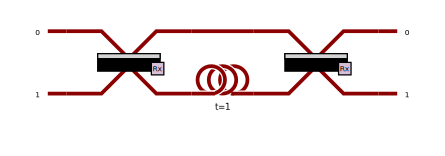

In [16]:
HOM = pcvl.Processor("SLOS", 2)

HOM.add(0, pcvl.BS())
HOM.add(1, pcvl.TD(1))
HOM.add(0, pcvl.BS())

pcvl.pdisplay(HOM)

In [17]:
from_perceval(HOM)

ValueError: Unsupported perceval component type: <class 'perceval.components.non_unitary_components.TD'>

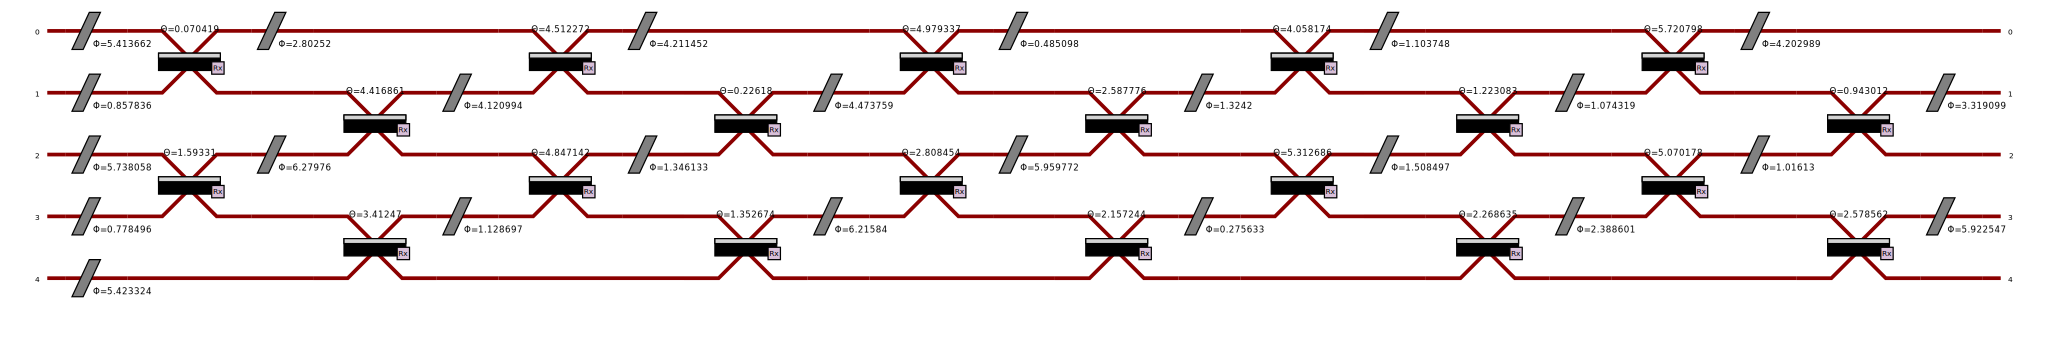

In [18]:
import datetime
import math
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
from tqdm.notebook import tqdm_notebook

import perceval as pcvl

N=5
n_try=10
n_iter=3
n_process=8
angle_min=-15
angle_max=30
angle_step=2
n_unitary=300
logfilebs='bsbasednotebook-opt'
logfilemzi='mzibasednotebook-opt'

bs = pcvl.GenericInterferometer(N,
                                lambda idx: pcvl.BS(theta=np.pi * 2 * random.random()) // (0, pcvl.PS(phi=np.pi * 2 * random.random())),
                                shape=pcvl.InterferometerShape.RECTANGLE,
                                depth=2 * N,
                                phase_shifter_fun_gen=lambda idx: pcvl.PS(phi=np.pi*2*random.random()))
pcvl.pdisplay(bs, recursive = True)

In [19]:
p = pcvl.Processor("SLOS", 5)
p.add(0, bs)

p_new = pcvl.Processor("SLOS", 5)
for c in p.flatten():
    p_new.add(c[0][0], c[1])

In [20]:
from_perceval(p_new).eval()

/home/mateuszkupper/Documents/optyx/optyx/optyx/_utils.py:117: RuntimeWarning: overflow encountered in scalar multiply
  res *= i
/home/mateuszkupper/Documents/optyx/optyx/optyx/core/zw.py:242: RuntimeWarning: invalid value encountered in power
  amp=multinomial(config) ** 0.5


KeyboardInterrupt: 

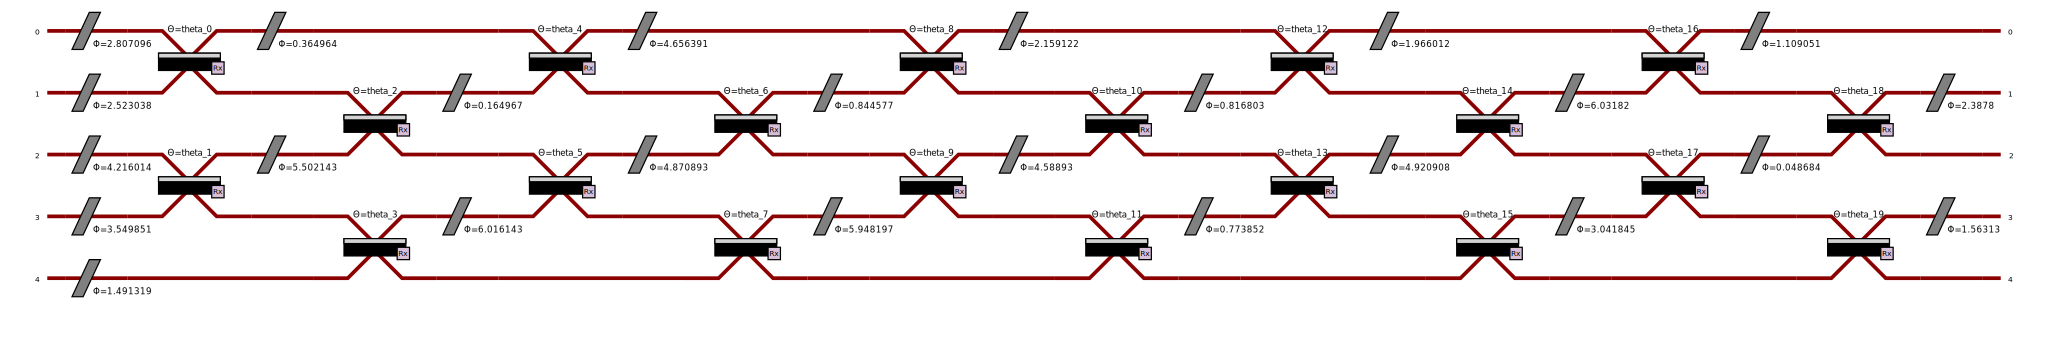

In [21]:
bs = pcvl.GenericInterferometer(N,
                                lambda idx: pcvl.BS(theta=pcvl.P("theta_%d" % idx)) // (0, pcvl.PS(phi=np.pi * 2 * random.random())),
                                shape=pcvl.InterferometerShape.RECTANGLE,
                                depth=2 * N,
                                phase_shifter_fun_gen=lambda idx: pcvl.PS(phi=np.pi*2*random.random()))
pcvl.pdisplay(bs, recursive = True)

In [22]:
bs.params

dict_keys(['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19'])

In [23]:
p = pcvl.Processor("SLOS", 5)
p.add(0, bs)

p_new = pcvl.Processor("SLOS", 5)
for c in p.flatten():
    p_new.add(c[0][0], c[1])

In [24]:
from_perceval(p_new)

Matrix([[cos(theta_0/2), I*sin(theta_0/2)], [I*sin(theta_0/2), cos(theta_0/2)]])


TypeError: Symbolic circuits are not currently supported

Optical circuit for Shor's algorithm


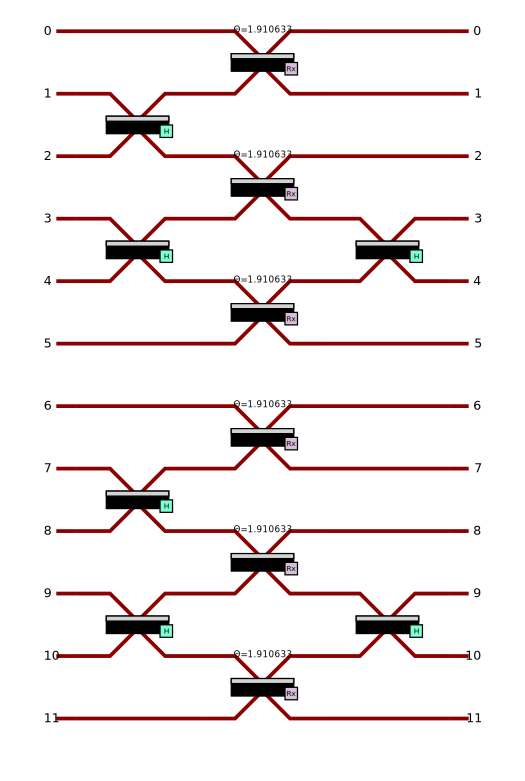

In [10]:
import perceval as pcvl
def toFockState(qubitState):
    # path encoding
    pe = {0:[1,0],  1:[0,1]}
    return [0] + pe[qubitState[0]] + pe[qubitState[2]] + [0, 0] + pe[qubitState[1]] + pe[qubitState[3]] + [0]
def toQubitState(fockState):
    # qubit modes
    x1 = [1, 2]
    f1 = [3, 4]
    x2 = [7, 8]
    f2 = [9, 10]
    # auxiliary modes
    am1 = [0, 5]
    am2 = [6, 11]

    # auxiliary modes
    for i in am1 + am2:
        if fockState[i]!=0:
            return None
    L=[]
    # qubit modes
    for q in [x1, x2, f1, f2]:
        if fockState[q[0]]+fockState[q[1]] != 1:
            return None
        else:
            L.append(fockState[q[1]])
    return L
def strState(state):
    return str(pcvl.BasicState(state))
circ = pcvl.Circuit(12)

# qubit modes
# for qubit states 0, 1
x1 = [1, 2]
f1 = [3, 4]
x2 = [7, 8]
f2 = [9, 10]
# auxiliary modes
am1 = [0, 5]
am2 = [6, 11]


# H gates
for q in [x1, f1, x2, f2]:
    circ.add(q, pcvl.BS.H())

# CZ gates
for x, f, am in [(x1, f1, am1), (x2, f2, am2)]:
    circ.add((am[0], x[0]), pcvl.BS(pcvl.BS.r_to_theta(1/3))) # R = 1/3
    circ.add((x[1],  f[0]), pcvl.BS(pcvl.BS.r_to_theta(1/3)))
    circ.add((f[1], am[1]), pcvl.BS(pcvl.BS.r_to_theta(1/3)))

# H gates
for q in [f1, f2]:
    circ.add(q, pcvl.BS.H())

print("Optical circuit for Shor's algorithm")
pcvl.pdisplay(circ)

In [11]:
qubit_istate = [0,0,0,1]
istate = toFockState(qubit_istate)

print("Input qubit state:", strState(qubit_istate))
print("Corresponding input Fock state:", strState(istate))
backend = pcvl.BackendFactory().get_backend("Naive")
backend.set_circuit(circ)
backend.set_input_state(pcvl.BasicState(istate))

Input qubit state: |0,0,0,1>
Corresponding input Fock state: |0,1,0,1,0,0,0,1,0,0,1,0>


In [12]:
input_states = {
    pcvl.BasicState(pcvl.BasicState(istate)): strState(qubit_istate)
}

expected_output_states = {
    pcvl.BasicState(toFockState([x1,x2,x1,1-x2])): strState([x1,x2,x1,1-x2])
    for x1 in [0,1] for x2 in [0,1]
}

p = pcvl.Processor("Naive", circ)

ca = pcvl.algorithm.Analyzer(p, input_states, expected_output_states)
ca.compute()

print("Output state distribution: (post-selected on expected qubit states, not renormalized)")
print("|x1,x2,f1,f2>")
pcvl.pdisplay(ca)

Output state distribution: (post-selected on expected qubit states, not renormalized)
|x1,x2,f1,f2>


,"|0,0,0,1>","|0,1,0,0>","|1,0,1,1>","|1,1,1,0>"
"|0,0,0,1>",0.003086,0.003086,0.003086,0.003086


In [13]:
input_states

{|0,1,0,1,0,0,0,1,0,0,1,0>: '|0,0,0,1>'}

In [14]:
expected_output_states

{|0,1,0,1,0,0,0,1,0,0,1,0>: '|0,0,0,1>',
 |0,1,0,1,0,0,0,0,1,1,0,0>: '|0,1,0,0>',
 |0,0,1,0,1,0,0,1,0,0,1,0>: '|1,0,1,1>',
 |0,0,1,0,1,0,0,0,1,1,0,0>: '|1,1,1,0>'}

In [15]:
p = pcvl.Processor("Naive", 12)
p.add(0, circ)

In [16]:
p_new = pcvl.Processor("Naive", 12)
for c in p.flatten():
    p_new.add(min(c[0]), c[1])

In [17]:
optyx_circ = from_perceval(p_new)

In [18]:
state_ = [0,1,0,1,0,0,0,1,0,0,1,0]
state_optyx = photonic.Create(*state_)

In [19]:
from optyx.classical import PostselectDigit

In [ ]:
from cotengra import ReusableHyperCompressedOptimizer
from optyx.core.backends import QuimbBackend
opt = ReusableHyperCompressedOptimizer(max_repeats=32)
backend = QuimbBackend(hyperoptimiser=opt, contraction_params={"chi":2})

(
    state_optyx >>
    optyx_circ >>
    Select(*[0,1,0,1,0,0,0,1,0,0,1,0])
).eval(backend=backend)

In [21]:
(
    state_optyx >>
    optyx_circ >>
    Select(*[0,1,0,1,0,0,0,1,0,0,1,0])
).is_pure

True

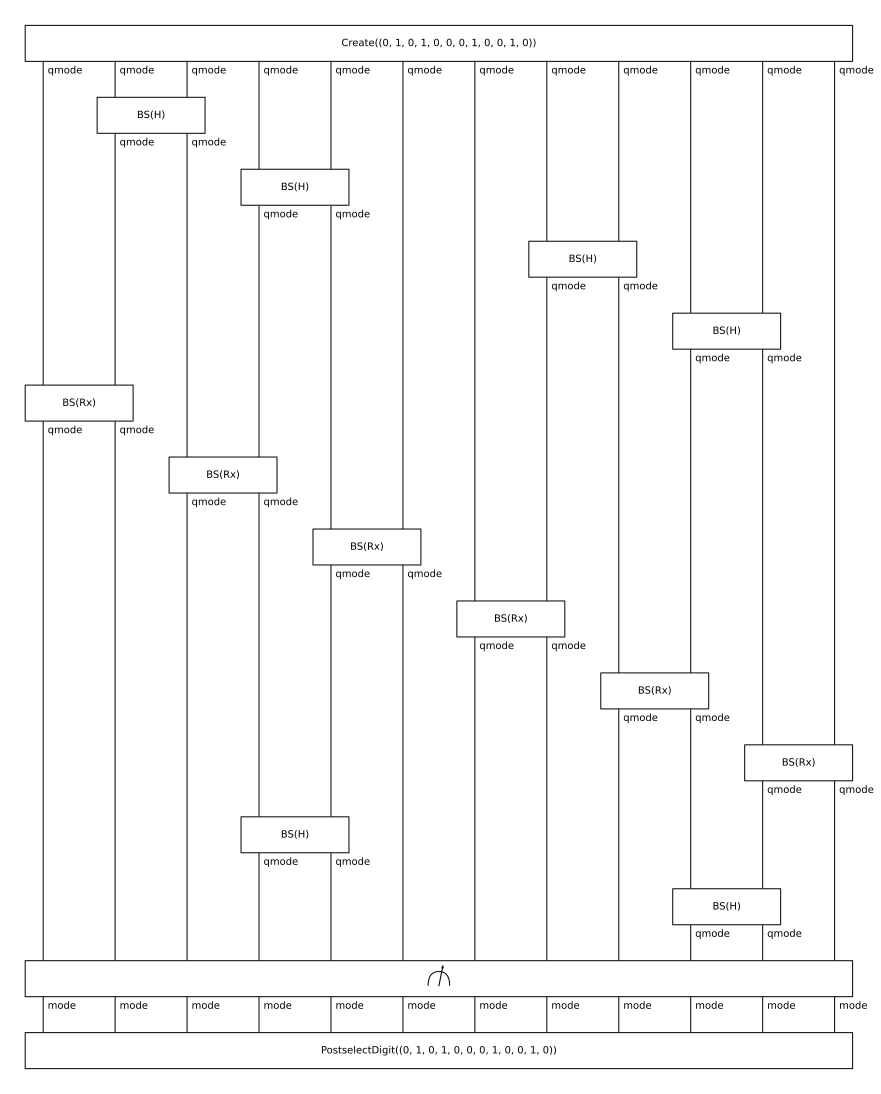

In [37]:
(
    state_optyx >>
    optyx_circ >>
    photonic.NumberResolvingMeasurement(12) >>
    PostselectDigit(*[0,1,0,1,0,0,0,1,0,0,1,0]) 
).draw()

In [28]:
import math

from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

import perceval as pcvl

Grover optical circuit for searching database element "00":


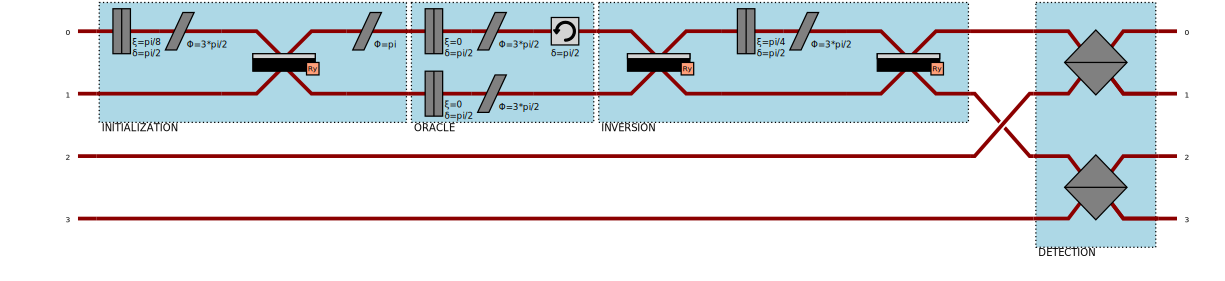

In [29]:
states = [pcvl.BasicState("|0,{P:H}>"),
          pcvl.BasicState("|0,{P:V}>"),
          pcvl.BasicState("|{P:H},0>"),
          pcvl.BasicState("|{P:V},0>"),
         ]

states_modes = [
    pcvl.BasicState([0, 0, 0, 1]),
    pcvl.BasicState([0, 0, 1, 0]),
    pcvl.BasicState([0, 1, 0, 0]),
    pcvl.BasicState([1, 0, 0, 0])
]
BS = pcvl.BS.Ry()
def HWP(xsi):
    hwp = pcvl.Circuit(m=1)
    hwp.add(0, pcvl.HWP(xsi)).add(0, pcvl.PS(-math.pi/2))
    return hwp

pcvl.pdisplay(HWP(math.pi/2))
init_circuit = (pcvl.Circuit(m=2, name="Initialization")
                // HWP(math.pi / 8)
                // BS
                // pcvl.PS(-math.pi))

pcvl.pdisplay(init_circuit)

def oracle(mark):
    """Values 0, 1, 2 and 3 for parameter 'mark' respectively mark the elements "00", "01", "10" and "11" of the list."""
    oracle_circuit = pcvl.Circuit(m=2, name='Oracle')
    # The following dictionary translates n into the corresponding component settings
    oracle_dict = {0: (1, 0), 1: (0, 1), 2: (1, 1), 3: (0, 0)}
    PC_state, LC_state = oracle_dict[mark]
    # Mode b
    if PC_state == 1:
        oracle_circuit //= HWP(0)
    oracle_circuit.add(0, pcvl.PR(math.pi/2))
    if LC_state == 1:
        oracle_circuit //= HWP(0)
    # Mode a
    if LC_state == 1:
        oracle_circuit //= (1, HWP(0))
    if PC_state == 1:
        oracle_circuit //= (1, HWP(0))
    return oracle_circuit

pcvl.pdisplay(oracle(0))

inversion_circuit = (pcvl.Circuit(m=2, name='Inversion')
                     // BS
                     // HWP(math.pi / 4)
                     // BS)

pcvl.pdisplay(inversion_circuit)

detection_circuit = pcvl.Circuit(m=4, name='Detection')
detection_circuit.add((0, 1), pcvl.PBS())
detection_circuit.add((2, 3), pcvl.PBS())

def grover_circuit(mark):
    grover_circuit = pcvl.Circuit(m=4, name='Grover')
    grover_circuit.add(0, init_circuit).add(0, oracle(mark)).add(0, inversion_circuit)
    grover_circuit.add(1, pcvl.PERM([1, 0])).add(0, detection_circuit)
    return grover_circuit

print('Grover optical circuit for searching database element "00":')
pcvl.pdisplay(grover_circuit(0), recursive=True)


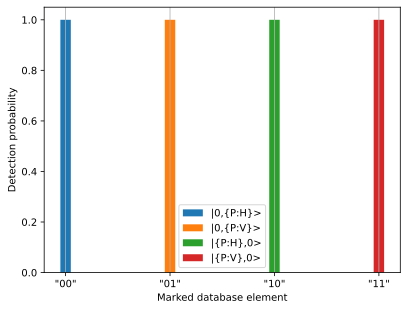

In [30]:
# Circuit simulation
input_state = pcvl.BasicState("|{P:H},0, 0, 0>")
results_list = []  # probability amplitudes storage

for mark in range(4):
    sim = pcvl.Processor("SLOS", grover_circuit(mark))
    ca = pcvl.algorithm.Analyzer(sim,
                              input_states=[input_state],
                              output_states=states_modes,
                             )
    results_list.append(ca.distribution[0])

# Plot data
labels = ['"00"', '"01"', '"10"', '"11"']
x = np.arange(4)  # label locations

fig, ax = plt.subplots(dpi=150)
for i in range(4):
    ax.bar(x, results_list[i].real, 0.1, label=str(states[i]))

ax.set_xlabel('Marked database element')
ax.set_ylabel('Detection probability')
ax.set_xticks(x, labels)
ax.legend()
ax.grid(True, axis='x')
plt.show()


In [31]:
p = pcvl.Processor("SLOS", 4)
p.add(0, grover_circuit(0))
p_new = pcvl.Processor("SLOS", 4)

for c in p.flatten():
    p_new.add(c[0][0], c[1])

In [37]:
p.flatten()[0][1].U

Matrix([
[0.707106781186548*I,  0.707106781186547*I],
[0.707106781186547*I, -0.707106781186548*I]])

In [42]:
p.flatten()

[([0], <perceval.components.unitary_components.HWP at 0x731242192240>),
 ([0], <perceval.components.unitary_components.PS at 0x7312421912e0>),
 ([0, 1], <perceval.components.unitary_components.BS at 0x7312418a2270>),
 ([0], <perceval.components.unitary_components.PS at 0x7312418a3440>),
 ([0], <perceval.components.unitary_components.HWP at 0x731241e3f320>),
 ([0], <perceval.components.unitary_components.PS at 0x7312418a3e00>),
 ([0], <perceval.components.unitary_components.PR at 0x731241e38bf0>),
 ([1], <perceval.components.unitary_components.HWP at 0x7312418a1ca0>),
 ([1], <perceval.components.unitary_components.PS at 0x7312418a3fb0>),
 ([0, 1], <perceval.components.unitary_components.BS at 0x7312418a2270>),
 ([0], <perceval.components.unitary_components.HWP at 0x731242191460>),
 ([0], <perceval.components.unitary_components.PS at 0x7312418d24b0>),
 ([0, 1], <perceval.components.unitary_components.BS at 0x7312418a2270>),
 ([1, 2], <perceval.components.unitary_components.PERM at 0x7312

In [68]:
from_perceval(p_new)

(2, 2)
1


ValueError: A component acting on polarisation modes.

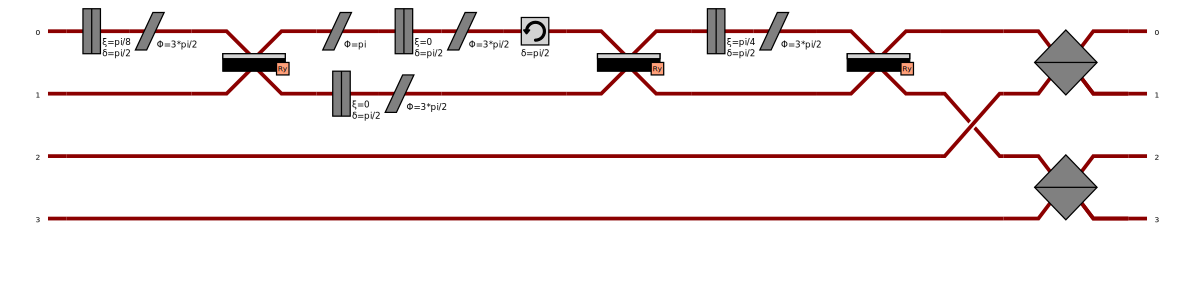

In [33]:
pcvl.pdisplay(p_new, recursive=True)

In [72]:
import math

import perceval as pcvl

p = pcvl.catalog['postprocessed cnot'].build_processor()

states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11"
}

ca = pcvl.algorithm.Analyzer(p, states)
ca.compute(expected={"00": "00", "01": "01", "10": "11", "11": "10"})
pcvl.pdisplay(ca)
print(f"performance = {pcvl.simple_float(ca.performance)[1]}, fidelity = {ca.fidelity*100}%")

,00,01,10,11
00,1,0,0,0
01,0,1,0,0
10,0,0,0,1
11,0,0,1,0


performance = 1/9, fidelity = 100.0%


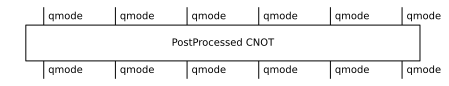

In [73]:
p_optyx = from_perceval(p)